# Multimodal RAG with Llava on SageMaker
In this notebook we'll implement a small-scale RAG system for multiple modalities. In particular we'll use the LlaVa with Mistral 7B model to generate summaries of all the images in our PDF files. Then we'll use those summaries as the basis for our index in a vector store.

This was described in a LangChain cookbook available [here!](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb?ref=blog.langchain.dev) This notebook heavily relies on that source code, and modifies it to work with SageMaker Endpoints in Studio.

You can upload a PDF document into a folder and specify the path and the filename below. Make sure to pick a paper with images, not just equations or tables. This way the `unstructured` library will generate new `.jpg` files in your current working directory.

---
#### Instance and endpoint requirements.
1. In this notebook you're running a LlaVA model locally, so start by moving onto a development environment with access to accelerators. I'm using the `ml.g5.2xlarge.`
2. Go create an endpoint in SageMaker Studio with a large language model for chat. I'm using Llama-2 70B Chat, this uses an `ml.g4.48xlarge`.
3. Go create an endpoint in SageMaker Studio with an embedding model. I'm using a GPT-J 6B embedding model, which uses an `ml.g5.12xlarge`.

### Step 1. Install requirements

In [ ]:
!pip install --upgrade pip

In [ ]:
%%writefile requirements.txt

bitsandbytes
torch
transformers>=4.39.1
accelerate
langchain 
chromadb 
langchain-experimental 
unstructured[all-docs]
pillow 
pydantic 
lxml 
pillow
matplotlib 
tiktoken
opencv-python-headless
boto3>=1.34.23
sqlalchemy
flask-sqlalchemy

In [58]:
!pip install sqlalchemy

In [ ]:
!pip install -r requirements.txt

In [ ]:
!apt-get update

In [ ]:
!apt-get install libgl1

In [ ]:
!apt-get install poppler-utils -y

In [ ]:
!apt install tesseract-ocr -y

Now restart your Jupyter notebook kernel just to be sure you have the new packages.

In [ ]:
import os
os._exit(00)

In [ ]:
import transformers

transformers.__version__

Make sure you have at least Transformers 4.39.1

In [ ]:
from unstructured.partition.pdf import partition_pdf

This package can be tricky, you need to be able to use it to break the PDF's into parts to use in the RAG system we're building. Make sure you can import this function successfully before continuing.

### Step 2. Download LlaVA locally and test.

In [2]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

llava_model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
!wget https://raw.githubusercontent.com/haotian-liu/LLaVA/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg 

![img](llava_v1_5_radar.jpg)

LlaVa seems to be able to answer only the most basic questions about this image, such as what is shown in the image and what it means. LlaVa is clearly not able to answer questions about interpreting the plot, such as identifying which models perform the highest and the lowest in terms of overall surface area.

In [3]:
# prepare image and text prompt, using the appropriate prompt template
image_fp = 'llava_v1_5_radar.jpg'

image = Image.open(image_fp)

# correct 
prompt = "[INST] <image>\nWhat is shown in this image? [/INST]"

# correct
# prompt = "[INST] <image>\ What is the meaning of this image? [/INST]"

# wrong
# prompt = "[INST] <image>\ Which model covers the most surface area in this plot? [/INST]"

# wrong
# prompt = "[INST] <image>\ Which models are shown in the legend in this plot?[/INST]"

# wrong 
# prompt = "[INST] <image>\ What model has the least surface area in this plot? [/INST]"


inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = llava_model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:391: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn('Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


[INST]  
What is shown in this image? [/INST] The image appears to be a radar chart, which is a type of multi-dimensional plot that displays values for multiple quantitative variables represented on axes starting from the same point. This particular radar chart is showing the performance of various models or systems across different metrics or datasets.

The chart is divided into several sections, each representing a different model or dataset. The axes represent different metrics or datasets, such as "MMM-Vet," "MMM-Bench," "L


### Step 3. Ingest PDFs using `unstructured`
Next we'll ingest a variety of PDF's using an open-source Python library. This will create new `.jpg` files for each image it identifies in the pdf files. This will show up in a new folder, in this current working directory, called `figures`.

In [4]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


In [59]:
# File path
fpath = "../papers/"
fname = "meaning.pdf"

# # Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

In [6]:
# # Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# # Optional: Enforce a specific token size for texts. 
# Make sure to pick something that fits in the context window of your model
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [22]:
texts_4k_token[0][:500]

'3 2 0 2\n\nv o N 9 2 ] L C . s c [\n\n3 v 8 4 3 8 1 . 0 1 3 2 : v i X r a\n\nMEANING REPRESENTATIONS FROM TRAJECTORIES IN AUTOREGRESSIVE MODELS Pramuditha Perera AWS AI Labs2 Luca Zancato AWS AI Labs2\n\nStefano Soatto AWS AI Labs2\n\nABSTRACT\n\nWe propose to extract meaning representations from autoregressive language models by considering the distribution of all possible trajectories extending an input text. This strategy is prompt-free, does not require fine-tuning, and is applicable to any pre-trained '

### Step 4. Initialize LangChain with a SageMaker endpoint and generate text summaries.
Now open up SageMaker Studio and select your preferred LLM for summarization. I'll use Llama-2 70B Chat.

You'll need to paste the endpoint name and the inference component name into the cell below. If you can't find the inference component name, look in SageMaker Studio, then test the endpoint in the UI directly. This should give you a box with the input and output JSON objects, and the inference component name should be there. Test the inference, and then click "Show Request" in the box on the right. This should have both the endpoint name and the inference component name.

In [24]:
from langchain import SagemakerEndpoint
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.llms.sagemaker_endpoint import LLMContentHandler
import os
import json

In [25]:
class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: dict) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode('utf-8')
    
    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        # this output is built to match Llama 2
        return response_json[0]["generated_text"]


In [26]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()

client = boto3.client('sagemaker-runtime')

template = '''You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} '''

prompt = ChatPromptTemplate.from_template(template)

content_handler = ContentHandler()

model = SagemakerEndpoint(
     endpoint_name = 'jumpstart-dft-meta-textgeneration-l-20240328-173404',
     client = client,
     model_kwargs={"max_new_tokens": 256, "top_p": 0.9, "temperature": 0.6},
     endpoint_kwargs={"CustomAttributes": "accept_eula=true",
                     "InferenceComponentName": "meta-textgeneration-llama-2-70b-f-20240328-173405"},
     content_handler=content_handler
 )

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [28]:
# check to make sure your connection to the chat model is healthy
model.invoke('Hi there LLM, how are you doing today?')

" I'm doing well, thanks for asking! I'm here to help answer any questions you might have, so feel free to ask me anything. I'm a large language model, so I can provide information on a wide range of topics, from science and history to entertainment and culture. I'm constantly learning and improving, so I can provide accurate and up-to-date information. I'm also designed to be friendly and approachable, so don't hesitate to ask me anything that's on your mind. So, what can I help you with today?"

In [29]:
# Generate summaries of text elements
 
def generate_text_summaries(texts, tables, summarize_chain, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """
    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
        
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries

In [30]:
# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_chain, summarize_texts=True
)

In [31]:
text_summaries[0]

'1.0 0.8 0.6 0.4 0.2 0.0 -0.2 -0.4 -0.6 -0.8 -1.0 Similarity Dissimilarity 1.0 0.8 0.6 0.4 0.2 0.0 -0.2 -0.4 -0.6 -0.8 -1.0 Similarity Dissimilarity Figure 1: Comparison of semantic similarity and dissimilarity between two sentences using our method. We sample 10-20 trajectories for each input sentence and compute the likelihood score for each pair of trajectories. The left panel shows the similarity between two sentences, and the right panel shows the dissimilarity. The scores are normalized to have a mean of 0 and a standard deviation of 1.\n\nWe represent sentences as the distribution of their possible continuations, or trajectories. This allows us to capture the meaning of sentences in a way that is not possible with traditional vector space representations. We show that our method achieves competitive performance on semantic similarity tasks and outperforms other zero-shot and prompt-free methods.'

### Step 5. Use the local Llava model to create image summaries
Next we'll loop through the `.jpg` files generated by `unstructured` in your folder, and send these to the local Llava model. Specifically we'll rewrite the `image_summarize` function to point to a local model.

In [32]:
import os
from langchain_core.messages import HumanMessage
import base64

def image_summarize(llava_model, image_path, prompt):
    
    image = Image.open(image_path)

    inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = llava_model.generate(**inputs, max_new_tokens=200)

    msg = processor.decode(output[0], skip_special_tokens=True)
    
    return msg

def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [60]:
def generate_img_summaries(path, llava_model):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = "[INST] <image> You are an assistant tasked with summarizing images for retrieval. \
            These summaries will be embedded and used to retrieve the raw image. \
            Give a concise summary of the image that is well optimized for retrieval. [/INST]"

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(llava_model, img_path, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries('figures', llava_model)

In [37]:
# make sure the image summaries look valid
image_summaries[0].split('[/INST]')[1]

' The image displays two bar graphs, each representing different data sets. The left graph is labeled "Number of Trajectories (n)" and shows a series of bars in various colors, each corresponding to a different trajectory. The right graph is labeled "Temperature (a)" and features a series of bars in a different color scheme, also representing different trajectories. The bars in both graphs are of varying heights, indicating different values for the respective data sets. The graphs are informative and appear to be part of a scientific or technical presentation. '

### Step 6. Create a mult-vector retrieval store
Next, we'll create a vector store and add the documents to this. This will store the raw text, tables, and images in the `docstore`. Then we'll store the texts, table summaries, and image summaries in the `vectorstore`.

To do this, we'll need to deploy an embedding model on SageMaker JumpStart. For this, simply navigate to SageMaker Studio, and select JumpStart. Within JumpStart, you can use the HuggingFace `gpt-j-6b` model. Deploy this to an endpoint, and paste the name of this resource below.

In [40]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [41]:
import json
from typing import Dict, List

from langchain_community.embeddings import SagemakerEndpointEmbeddings
from langchain_community.embeddings.sagemaker_endpoint import EmbeddingsContentHandler

class ContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: list[str], model_kwargs: Dict) -> bytes:
        """
        Transforms the input into bytes that can be consumed by SageMaker endpoint.
        Args:
            text_inputs: List of input strings.
            model_kwargs: Additional keyword arguments to be passed to the endpoint.
        Returns:
            The transformed bytes input.
        """
        # Example: inference.py expects a JSON string with a "inputs" key:
        input_str = json.dumps({"text_inputs": inputs, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> List[List[float]]:
        """
        Transforms the bytes output from the endpoint into a list of embeddings.
        Args:
            output: The bytes output from SageMaker endpoint.
        Returns:
            The transformed output - list of embeddings
        Note:
            The length of the outer list is the number of input strings.
            The length of the inner lists is the embedding dimension.
        """
        # Example: inference.py returns a JSON string with the list of
        # embeddings in a "vectors" key:
        model_predictions = json.loads(output.read())
        embeddings = model_predictions['embedding']
        return embeddings

client = boto3.client(
    "sagemaker-runtime"
)
embeddings = SagemakerEndpointEmbeddings(
    endpoint_name="jumpstart-dft-hf-textembedding-gpt-20240328-181051",
    client=client,
    content_handler=ContentHandler(),
)

In [42]:
def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [43]:
# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="llava-rag-sagemaker", embedding_function=embeddings
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [44]:
vectorstore

In [45]:
retriever_multi_vector_img

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7ff852f97340>, docstore=<langchain.storage.in_memory.InMemoryBaseStore object at 0x7ff852f95570>)

### Step 7. Build the full retrieval-augmeneted generation workflow

In [46]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an AI scientist tasked with providing guidance on AI research projects.\n"
            "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide AI research advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [48]:
def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Chat LLM
    model = SagemakerEndpoint(
     endpoint_name = 'jumpstart-dft-meta-textgeneration-l-20240328-173404',
     client = client,
     model_kwargs={"max_new_tokens": 256, "top_p": 0.9, "temperature": 0.6},
     endpoint_kwargs={"CustomAttributes": "accept_eula=true",
                     "InferenceComponentName": "meta-textgeneration-llama-2-70b-f-20240328-173405"},
     content_handler=content_handler
     )
    

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

### Step 8. Check the retriever
This solution can take text-based questions, and look up relevant content from either text or image sources.

In [50]:
# Check retrieval
query = "Give me papers that are related to large language models."

docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

# We get 4 docs
len(docs)

4


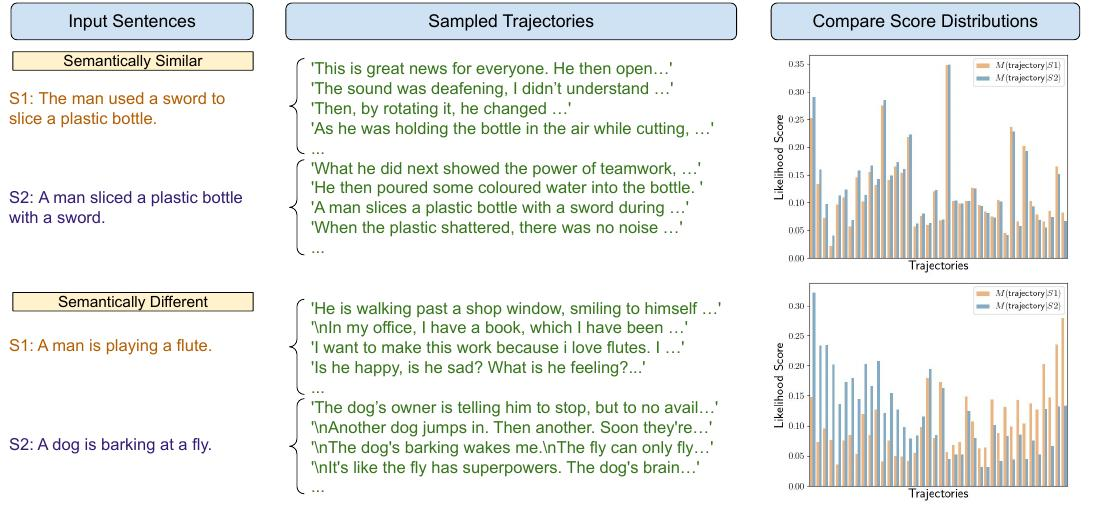

In [53]:
plt_img_base64(docs[0])

In [51]:
# Check retrieval
query = "Give me papers that are about multimodal retrieval."

docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

# We get 4 docs
len(docs)

4


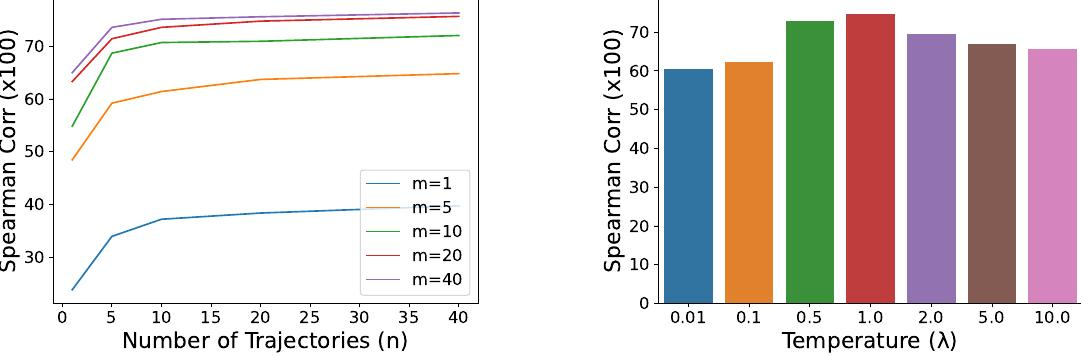

In [56]:
plt_img_base64(docs[3])